In [1]:
pip install torchcde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 4.6 MB/s eta 0:00:00


[*********************100%***********************]  1 of 1 completed


Epoch [10/300], Loss: 0.9177
Epoch [20/300], Loss: 0.7135
Epoch [30/300], Loss: 0.4673
Epoch [40/300], Loss: 0.3125
Epoch [50/300], Loss: 0.2869
Epoch [60/300], Loss: 0.2677
Epoch [70/300], Loss: 0.2685
Epoch [80/300], Loss: 0.2663
Epoch [90/300], Loss: 0.2649
Epoch [100/300], Loss: 0.2637
Epoch [110/300], Loss: 0.2626
Epoch [120/300], Loss: 0.2614
Epoch [130/300], Loss: 0.2601
Epoch [140/300], Loss: 0.2586
Epoch [150/300], Loss: 0.2568
Epoch [160/300], Loss: 0.2548
Epoch [170/300], Loss: 0.2524
Epoch [180/300], Loss: 0.2496
Epoch [190/300], Loss: 0.2463
Epoch [200/300], Loss: 0.2423
Epoch [210/300], Loss: 0.2378
Epoch [220/300], Loss: 0.2329
Epoch [230/300], Loss: 0.2278
Epoch [240/300], Loss: 0.2231
Epoch [250/300], Loss: 0.2190
Epoch [260/300], Loss: 0.2158
Epoch [270/300], Loss: 0.2134
Epoch [280/300], Loss: 0.2118
Epoch [290/300], Loss: 0.2105
Epoch [300/300], Loss: 0.2093

평균 제곱근 오차 (RMSE): 352.4369
평균 절대 오차 (MAE): 264.0254
평균 절대 백분율 오차 (MAPE): 1.50%

[Open]
  RMSE: 365.2039
  MA

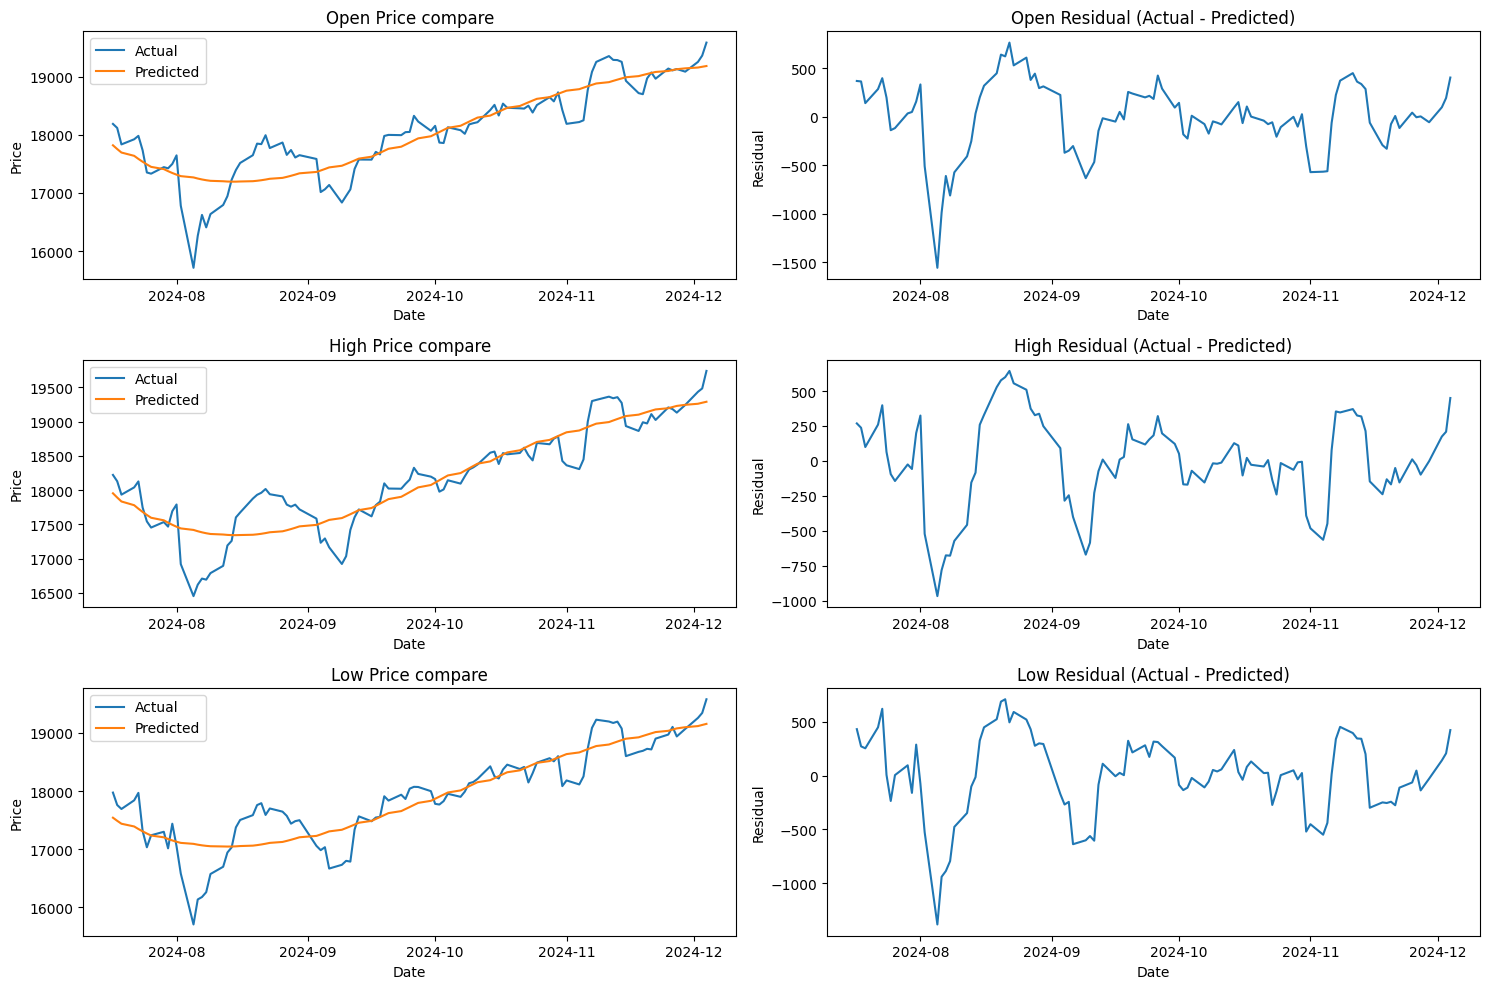

In [2]:
import torch
import torchcde
import torch.nn as nn
import torch.optim as optim
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 하이퍼파라미터 설정
batch_size = 1
length = 100
input_channels = 4
hidden_channels = 5
output_channels = 3
epochs = 300
learning_rate = 0.01

# Yahoo Finance에서 데이터 다운로드
nasdaq_data = yf.download('^IXIC', period='6mo', interval='1d')
nasdaq_data = nasdaq_data[['Open', 'High', 'Low']].dropna()

# 데이터를 텐서로 변환하고 정규화
nasdaq_values = nasdaq_data.values[-length:]
if len(nasdaq_values) < length:
    raise ValueError("데이터의 길이가 충분하지 않습니다.")

# 데이터 정규화 (평균 0, 표준편차 1)
mean = nasdaq_values.mean(axis=0)
std = nasdaq_values.std(axis=0)
nasdaq_values_normalized = (nasdaq_values - mean) / std

nasdaq_tensor = torch.tensor(nasdaq_values_normalized, dtype=torch.float32).unsqueeze(0)

t_values = torch.linspace(0, 1, nasdaq_tensor.shape[1])
t_ = t_values.unsqueeze(0).unsqueeze(-1).expand(batch_size, nasdaq_tensor.shape[1], 1)
x = torch.cat([t_, nasdaq_tensor], dim=2)

# Cubic Hermite Spline method 사용
coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(x)
X = torchcde.CubicSpline(coeffs)

# Neural CDE 모델 정의
class CDEFunc(nn.Module):
    def __init__(self, hidden_channels, input_channels):
        super(CDEFunc, self).__init__()
        self.linear = nn.Linear(hidden_channels, hidden_channels * input_channels)
        self.hidden_channels = hidden_channels
        self.input_channels = input_channels

    def forward(self, t, z):
        z = self.linear(z)
        z = z.view(z.size(0), self.hidden_channels, self.input_channels)
        return z

class NeuralCDE(nn.Module):
    def __init__(self, input_channels, hidden_channels, output_channels):
        super(NeuralCDE, self).__init__()
        self.func = CDEFunc(hidden_channels, input_channels)
        self.initial = nn.Linear(input_channels, hidden_channels)
        self.readout = nn.Linear(hidden_channels, output_channels)

    def forward(self, X, t):
        z0 = self.initial(X.evaluate(X.interval[0]))
        z_T = torchcde.cdeint(X=X, func=self.func, z0=z0, t=t)
        pred_y = self.readout(z_T)
        return pred_y

model = NeuralCDE(input_channels=input_channels, hidden_channels=hidden_channels, output_channels=output_channels)

# 손실 함수와 옵티마이저 정의
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 타겟 데이터 설정 (다음 시간 스텝의 데이터를 예측하도록 설정)
target_length = nasdaq_tensor.shape[1] - 1
target_data = nasdaq_values_normalized[1:]
target_data = torch.tensor(target_data, dtype=torch.float32).unsqueeze(0)

# 훈련 루프
for epoch in range(epochs):
    optimizer.zero_grad()
    t = t_values[:-1]
    pred_y = model(X, t)
    loss = loss_function(pred_y, target_data)
    loss.backward()
    optimizer.step()

    # 10 epoch마다 손실 출력
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

pred_y = pred_y.detach().numpy()[0]
pred_y_denormalized = pred_y * std + mean

target_denormalized = target_data.detach().numpy()[0] * std + mean

dates = nasdaq_data.index[-length + 1:]

# 실제값과 예측값의 residual 계산
residuals = target_denormalized - pred_y_denormalized

# RMSE, MAE, MAPE 계산
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(target_denormalized, pred_y_denormalized)
rmse = np.sqrt(mse)
mae = mean_absolute_error(target_denormalized, pred_y_denormalized)
mape = np.mean(np.abs((target_denormalized - pred_y_denormalized) / target_denormalized)) * 100

print(f"\n평균 제곱근 오차 (RMSE): {rmse:.4f}")
print(f"평균 절대 오차 (MAE): {mae:.4f}")
print(f"평균 절대 백분율 오차 (MAPE): {mape:.2f}%")

# 피처별 오차 계산 및 출력
features = ['Open', 'High', 'Low']
for i, feature in enumerate(features):
    mse_feature = mean_squared_error(target_denormalized[:, i], pred_y_denormalized[:, i])
    rmse_feature = np.sqrt(mse_feature)
    mae_feature = mean_absolute_error(target_denormalized[:, i], pred_y_denormalized[:, i])
    mape_feature = np.mean(np.abs((target_denormalized[:, i] - pred_y_denormalized[:, i]) / target_denormalized[:, i])) * 100
    print(f"\n[{feature}]")
    print(f"  RMSE: {rmse_feature:.4f}")
    print(f"  MAE: {mae_feature:.4f}")
    print(f"  MAPE: {mape_feature:.2f}%")

# 시각화
plt.figure(figsize=(15, 10))

# 실제값과 예측값 비교 그래프 및 잔차 그래프
for i, label in enumerate(features):
    plt.subplot(3, 2, 2 * i + 1)
    plt.plot(dates, target_denormalized[:, i], label='Actual')
    plt.plot(dates, pred_y_denormalized[:, i], label='Predicted')
    plt.title(f'{label} Price compare')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()

    # 잔차 그래프
    plt.subplot(3, 2, 2 * i + 2)
    plt.plot(dates, residuals[:, i])
    plt.title(f'{label} Residual (Actual - Predicted)')
    plt.xlabel('Date')
    plt.ylabel('Residual')

plt.tight_layout()
plt.show()


[*********************100%***********************]  1 of 1 completed


Epoch [10/300], Loss: 1.0151
Epoch [20/300], Loss: 1.0085
Epoch [30/300], Loss: 1.0074
Epoch [40/300], Loss: 1.0048
Epoch [50/300], Loss: 1.0037
Epoch [60/300], Loss: 1.0029
Epoch [70/300], Loss: 1.0019
Epoch [80/300], Loss: 1.0007
Epoch [90/300], Loss: 0.9992
Epoch [100/300], Loss: 0.9973
Epoch [110/300], Loss: 0.9947
Epoch [120/300], Loss: 0.9911
Epoch [130/300], Loss: 0.9858
Epoch [140/300], Loss: 0.9778
Epoch [150/300], Loss: 0.9655
Epoch [160/300], Loss: 0.9456
Epoch [170/300], Loss: 0.9133
Epoch [180/300], Loss: 0.8614
Epoch [190/300], Loss: 0.7813
Epoch [200/300], Loss: 0.6690
Epoch [210/300], Loss: 0.5327
Epoch [220/300], Loss: 0.4046
Epoch [230/300], Loss: 0.3295
Epoch [240/300], Loss: 0.3132
Epoch [250/300], Loss: 0.3131
Epoch [260/300], Loss: 0.3122
Epoch [270/300], Loss: 0.3107
Epoch [280/300], Loss: 0.3103
Epoch [290/300], Loss: 0.3100
Epoch [300/300], Loss: 0.3101

평균 제곱근 오차 (RMSE): 428.3590
평균 절대 오차 (MAE): 308.7042
평균 절대 백분율 오차 (MAPE): 1.75%

[Open]
  RMSE: 442.3723
  MA

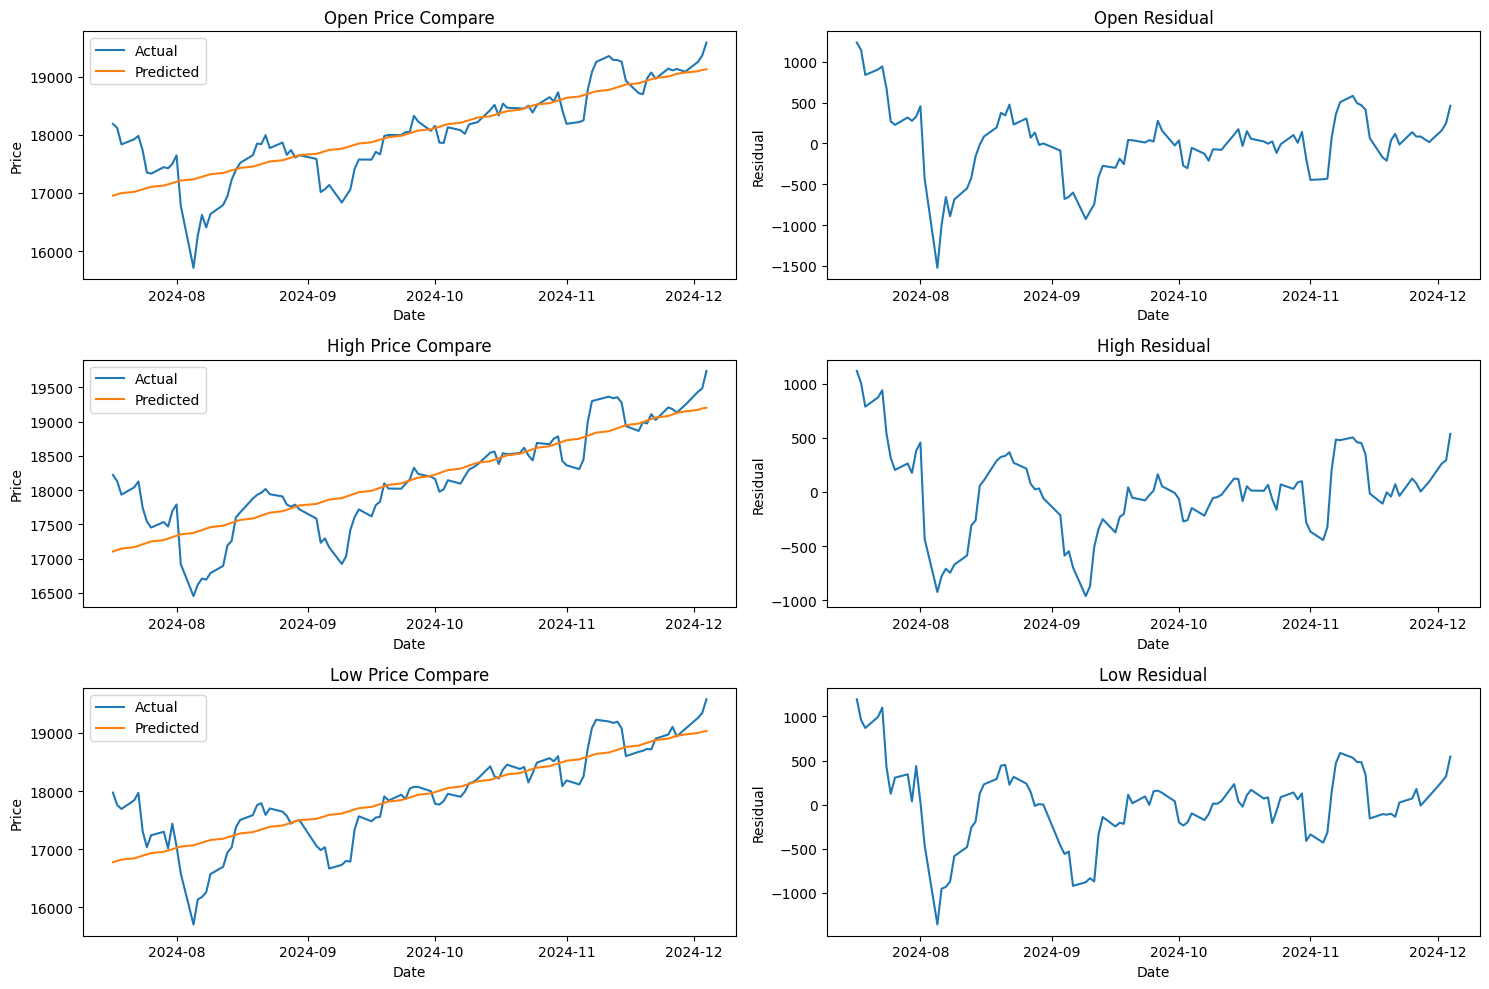

In [3]:
import torch
import torchcde
import torch.nn as nn
import torch.optim as optim
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 하이퍼파라미터 설정
batch_size = 1
length = 100           # 사용할 시계열 데이터 길이
input_channels = 4     # 입력 채널 (시간 + 3개 피처)
hidden_channels = 5    # 숨겨진 상태 채널
output_channels = 3    # 출력 채널
epochs = 300           # 학습 에포크 수
learning_rate = 0.01   # 학습률

# Yahoo Finance에서 데이터 다운로드
nasdaq_data = yf.download('^IXIC', period='6mo', interval='1d')
nasdaq_data = nasdaq_data[['Open', 'High', 'Low']].dropna()

# 데이터를 텐서로 변환하고 정규화
nasdaq_values = nasdaq_data.values[-length:]
if len(nasdaq_values) < length:
    raise ValueError("데이터의 길이가 충분하지 않습니다.")

mean = nasdaq_values.mean(axis=0)
std = nasdaq_values.std(axis=0)
nasdaq_values_normalized = (nasdaq_values - mean) / std

nasdaq_tensor = torch.tensor(nasdaq_values_normalized, dtype=torch.float32).unsqueeze(0)

# 시간 값을 추가하여 입력 데이터 생성
t_values = torch.linspace(0, 1, nasdaq_tensor.shape[1])
t_ = t_values.unsqueeze(0).unsqueeze(-1).expand(batch_size, nasdaq_tensor.shape[1], 1)
x = torch.cat([t_, nasdaq_tensor], dim=2)

# Rectilinear Control 경로 생성
coeffs = torchcde.linear_interpolation_coeffs(x, rectilinear=0)
X = torchcde.LinearInterpolation(coeffs)

# Neural CDE 모델 정의
class CDEFunc(nn.Module):
    def __init__(self, hidden_channels, input_channels):
        super(CDEFunc, self).__init__()
        self.linear = nn.Linear(hidden_channels, hidden_channels * input_channels)

    def forward(self, t, z):
        z = self.linear(z)
        z = z.view(z.size(0), hidden_channels, input_channels)
        return z

class NeuralCDE(nn.Module):
    def __init__(self, input_channels, hidden_channels, output_channels):
        super(NeuralCDE, self).__init__()
        self.func = CDEFunc(hidden_channels, input_channels)
        self.initial = nn.Linear(input_channels, hidden_channels)
        self.readout = nn.Linear(hidden_channels, output_channels)

    def forward(self, X, t):
        z0 = self.initial(X.evaluate(X.interval[0]))
        z_T = torchcde.cdeint(X=X, func=self.func, z0=z0, t=t)
        pred_y = self.readout(z_T)
        return pred_y

model = NeuralCDE(input_channels=input_channels, hidden_channels=hidden_channels, output_channels=output_channels)

# 손실 함수와 옵티마이저 정의
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 타겟 데이터 설정
target_length = nasdaq_tensor.shape[1] - 1
target_data = nasdaq_values_normalized[1:]
target_data = torch.tensor(target_data, dtype=torch.float32).unsqueeze(0)

# 훈련 루프
for epoch in range(epochs):
    optimizer.zero_grad()
    t = t_values[:-1]
    pred_y = model(X, t)
    loss = loss_function(pred_y, target_data)
    loss.backward()
    optimizer.step()

    # 10 epoch마다 손실 출력
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# 예측값 복원 및 시각화
pred_y = pred_y.detach().numpy()[0]
pred_y_denormalized = pred_y * std + mean
target_denormalized = target_data.detach().numpy()[0] * std + mean
dates = nasdaq_data.index[-length + 1:]

# RMSE, MAE, MAPE 계산
mse = mean_squared_error(target_denormalized, pred_y_denormalized)
rmse = np.sqrt(mse)
mae = mean_absolute_error(target_denormalized, pred_y_denormalized)
mape = np.mean(np.abs((target_denormalized - pred_y_denormalized) / target_denormalized)) * 100

print(f"\n평균 제곱근 오차 (RMSE): {rmse:.4f}")
print(f"평균 절대 오차 (MAE): {mae:.4f}")
print(f"평균 절대 백분율 오차 (MAPE): {mape:.2f}%")

# 피처별 오차 계산
features = ['Open', 'High', 'Low']
for i, feature in enumerate(features):
    mse_feature = mean_squared_error(target_denormalized[:, i], pred_y_denormalized[:, i])
    rmse_feature = np.sqrt(mse_feature)
    mae_feature = mean_absolute_error(target_denormalized[:, i], pred_y_denormalized[:, i])
    mape_feature = np.mean(np.abs((target_denormalized[:, i] - pred_y_denormalized[:, i]) / target_denormalized[:, i])) * 100
    print(f"\n[{feature}]")
    print(f"  RMSE: {rmse_feature:.4f}")
    print(f"  MAE: {mae_feature:.4f}")
    print(f"  MAPE: {mape_feature:.2f}%")

# 시각화
plt.figure(figsize=(15, 10))

for i, label in enumerate(features):
    plt.subplot(3, 2, 2 * i + 1)
    plt.plot(dates, target_denormalized[:, i], label='Actual')
    plt.plot(dates, pred_y_denormalized[:, i], label='Predicted')
    plt.title(f'{label} Price Compare')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()

    plt.subplot(3, 2, 2 * i + 2)
    plt.plot(dates, target_denormalized[:, i] - pred_y_denormalized[:, i])
    plt.title(f'{label} Residual')
    plt.xlabel('Date')
    plt.ylabel('Residual')

plt.tight_layout()
plt.show()
